In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#import fasttext
import codecs
from tqdm import tqdm

2022-03-14 22:32:02.385351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_test.csv')

train = train.drop(['TR','AG'],1)
test = test.drop(['TR','AG'],1)
val = val.drop(['TR','AG'],1)

/tmp/ipykernel_13279/157768247.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR','AG'],1)
/tmp/ipykernel_13279/157768247.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR','AG'],1)
/tmp/ipykernel_13279/157768247.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR','AG'],1)


<AxesSubplot:xlabel='HS', ylabel='count'>

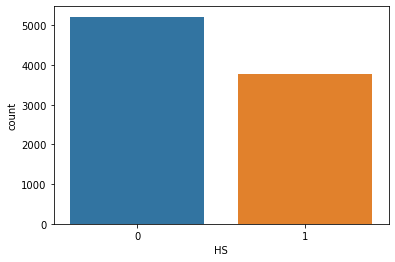

In [3]:
sns.countplot(data=train,x='HS')

Unbalanced but not massively

Fasttext model. tokenizer->fast text embedding ->LSTM->Linear->linear->sigmoid

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L1,L2, l1_l2
import io

In [5]:
def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    y = data['HS']
    return X, y

In [6]:
#Split x and ys
x_train, y_train = x_y_split(train)

In [7]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(x_train)
def tokenize_and_pad(x_data,tokenizer=tokenizer,length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data,maxlen=length)
    return x_data
x_train = tokenize_and_pad(x_train,tokenizer)
def split_and_tokenize(data,tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y

In [8]:
x_val , y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)

In [84]:
embed_dim = 300
lstm_out = 392
input_length=x_train.shape[1]

In [10]:
#https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('data/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))



loading word embeddings...


999995it [00:41, 23842.43it/s]

found 999995 word vectors


In [11]:
#embedding matrix
nb_words = min(max_features, len(tokenizer.word_index))
words_not_found = []
embedding_matrix = np.zeros((nb_words,embed_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 571


In [12]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['cdnpoli' 'repwilson' 'chengonsol' 'stoptheinvasion' 'refugeesnotwelcome'
 'breitbartnews' 'uscis' 'liberalismisamentaldisorder' 'matthewsoerens'
 'fridaymotivation']


In [85]:
REG_STRENGTH_l1 = 0
REG_STRENGTH_l2 = 0.05
model = Sequential()
model.add(Embedding(max_features,embed_dim,input_length=input_length, weights=[embedding_matrix],trainable=False))
model.add(LSTM(lstm_out,dropout=0.5, kernel_regularizer=L2(REG_STRENGTH_l2)))
model.add(Dense(256,activation='relu', kernel_regularizer=L2(REG_STRENGTH_l2)))
model.add(Dropout(.65))
model.add(Dense(256,activation='relu', kernel_regularizer=L2(REG_STRENGTH_l2)))
model.add(Dropout(.65))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
#print(model.summary())

In [86]:
filepath = 'checkpoints/test.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks = [checkpoint]

history = model.fit(x=x_train,
                    y=y_train,batch_size=256,
                    validation_data=(x_val,y_val),
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
36/36 [==============================] - 2s 34ms/step - loss: 52.3000 - accuracy: 0.5635 - val_loss: 46.8529 - val_accuracy: 0.5800

Epoch 00001: val_loss improved from inf to 46.85291, saving model to checkpoints/test.hdf5
Epoch 2/100
36/36 [==============================] - 1s 28ms/step - loss: 45.1954 - accuracy: 0.5782 - val_loss: 40.4975 - val_accuracy: 0.5800

Epoch 00002: val_loss improved from 46.85291 to 40.49754, saving model to checkpoints/test.hdf5
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 39.0667 - accuracy: 0.5802 - val_loss: 35.0295 - val_accuracy: 0.5800

Epoch 00003: val_loss improved from 40.49754 to 35.02955, saving model to checkpoints/test.hdf5
Epoch 4/100
36/36 [==============================] - 1s 31ms/step - loss: 33.7886 - accuracy: 0.5751 - val_loss: 30.3224 - val_accuracy: 0.5803

Epoch 00004: val_loss improved from 35.02955 to 30.32239, saving model to checkpoints/test.hdf5
Epoch 5/100
36/36 [======================

In [15]:
def plot_accuracy_loss_chart(history,epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

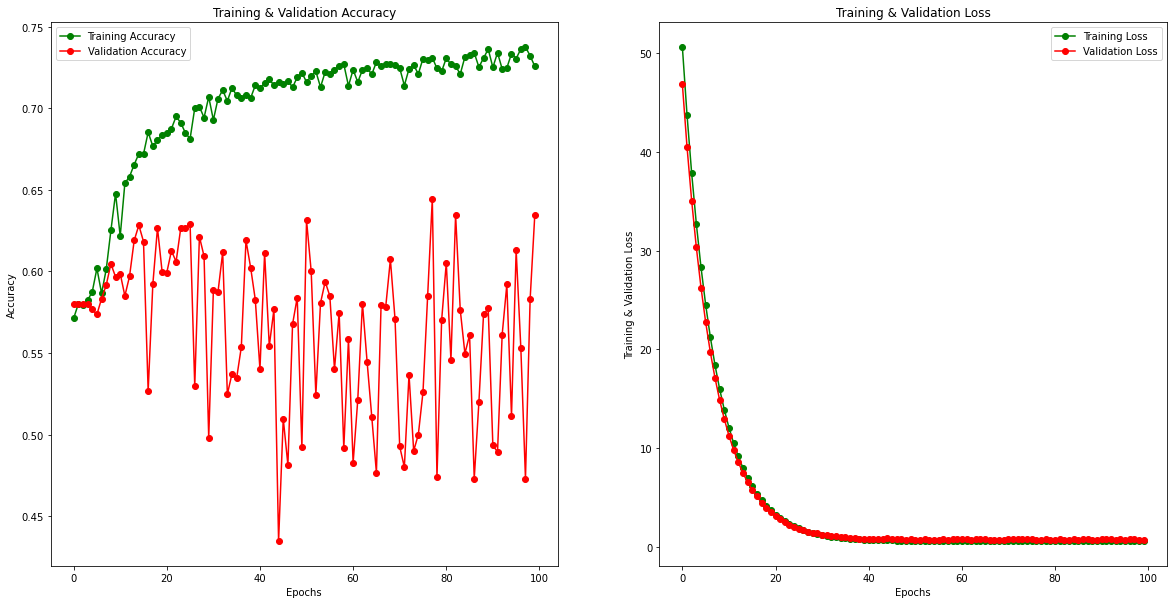

In [87]:
plot_accuracy_loss_chart(history,100)

In [93]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
pred = np.round(pred)
#print(pred)
print(classification_report(y_test,pred))



              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1740
           1       0.56      0.61      0.58      1260

    accuracy                           0.63      3000
   macro avg       0.63      0.63      0.63      3000
weighted avg       0.64      0.63      0.64      3000

